In [1]:
import pandas as pd
import math
import numpy as np

%matplotlib inline

from pathlib import Path
from omegaconf import OmegaConf
import scipy.stats as st

In [2]:
# Collect predictions

def check_num_epochs(run):
    if Path(run / "valid_log.csv").is_file():
        cfg = OmegaConf.load(run / '.hydra' / 'config.yaml')
        cfg = OmegaConf.to_container(cfg)
        num_epochs = cfg['optim']['epochs']

        valid_log = pd.read_csv(run / "valid_log.csv", header=None, index_col=0)
        if (len(valid_log.index)-3) < num_epochs:
            print("Wrong number of epochs in run: {}".format(run))
    else:
        print("valid_log.csv not exists in run: {}".format(run))

def check_only_one_tensorboard(run):
    len(list(Path('.').glob('*')))
    if len(list(Path(run / "runs").glob('*'))) > 1:
        print("More than 1 tensorboard folder in run: {}".format(run))

def check_image_size(run, image_size=480):
    cfg = OmegaConf.load(run / '.hydra' / 'config.yaml')
    cfg = OmegaConf.to_container(cfg)
    conf_image_size = cfg['data']['image_size']
    if int(conf_image_size) != image_size:
        print("Different image size in conf. Image size in conf: {}, Image size: {}".format(conf_image_size, image_size))

def collect_one(model_name, run, csv_file, image_size=480):
    check_num_epochs(run)
    check_only_one_tensorboard(run)
    check_image_size(run, image_size=image_size)
    
    cfg = OmegaConf.load(run / '.hydra' / 'config.yaml')
    cfg = OmegaConf.to_container(cfg)

    run_number = cfg['data']['train']['cross_val_bucket_validation_index']
    regime, inv_temp = float(run.parent.parts[-1].rsplit('-', 1)[1]), float(run.parent.parts[-2].rsplit('-', 1)[1])

    csv_path = run / 'test_predictions' / csv_file
    if not csv_path.exists():
        print(f'Skipping not found: {csv_path}')
        return pd.DataFrame()
    
    data = pd.read_csv(csv_path)
    if data.empty:
        print(f'Pred file is empty: {csv_path}')

    data['model'] = model_name
    data['run_number'] = run_number
    data['inv_temp'] = inv_temp
    data['regime'] = regime
    
    return data

def collect_all(model_name, root, csv_file, regimes=['0.01', '0.02', '0.05', '0.1', '0.2', '0.25', '1.0'], image_size=480, ignore_outliers=True):
    root = Path(root)

    metrics = []
    for inv_temp in list(root.glob("inv_temp-*")):
        for regime in list(inv_temp.glob("regime-*")):
            if regime.name.rsplit("-", 1)[1] in regimes:
                for run in list(regime.glob("run-*")):
                    if ignore_outliers and 'outlier' in run.as_posix():
                        continue
                    else:
                        metrics.append(collect_one(model_name, run, csv_file, image_size=image_size))
        
    metrics = pd.concat(metrics, ignore_index=True)
    
    return metrics

def collect_all_temperature(model_name, root, csv_file, regimes=['0.01', '0.02', '0.05', '0.1', '0.2', '0.25', '1.0'], image_size=480, ignore_outliers=True):
    root = Path(root)

    metrics = []
    for regime in list(root.glob("regime-*")):
        if regime.name.rsplit("-", 1)[1] in regimes:
            for run in list(regime.glob("run-*")):
                if ignore_outliers and 'outlier' in run.as_posix():
                    continue
                else:
                    metrics.append(collect_one(model_name, run, csv_file, image_size=image_size))
        
    metrics = pd.concat(metrics, ignore_index=True)
    
    return metrics

In [3]:
# Compute metrics for each detected run

def compute_metrics(data, grouping, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance']):
    metrics_dict_names = {
        'Dice': 'dice',
        'Jaccard': 'jaccard',
        'Hausdorff Distance': '95hd',
        'Average Surface Distance': 'asd'
    }

    columns = ['Model', '# Run', 'Inv Temp', 'Regime']
    columns.extend(metric_names)
    metrics = []
    
    data = data.copy().reset_index()
    grouped = data.groupby(grouping)
    
    for model_group, predictions in grouped:
        model_name, run_number, inv_temp, regime = model_group[0], model_group[1], model_group[2], model_group[3]
        
        metric_values = []
        for metric_name in metric_names:
            values = predictions['segm/{}'.format(metrics_dict_names[metric_name])].values
            mean_value = np.nanmean(values)
            if metric_name == 'Dice' or metric_name == 'Jaccard':
                metric_values.append((math.ceil(mean_value*10000)/10000)*100)
            else:
                if not np.isnan(mean_value):
                    metric_values.append(math.ceil(mean_value*100)/100)
                else:
                    metric_values.append(mean_value)
        
        metrics.append([model_name, run_number, inv_temp, regime, *metric_values])
        
    metrics_df = pd.DataFrame(metrics, columns=columns)
    
    return metrics_df

def summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90, return_ranges=False):

    def compute_ci(values, return_ranges=False):
        ci = st.t.interval(confidence_level, len(values)-1, loc=np.mean(values), scale=np.std(values)/(len(values)**0.5))

        if return_ranges:
            return ci
        else:
            return (ci[1]-ci[0]) / 2

    #mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ('STD', np.std), ("CI {}%".format(confidence_level), compute_ci)])
    mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)]) 

    return mean_metrics

<h1>GlaS Dataset</h1>

<h2>Evaluation - Searching temperature hyperparameter</h2>

<p>Evaluate Hebbian models belonging to SWTA paradigm to search best temperature values (this value is dataset-specific)</p>

In [4]:
# Unsupervised learning models are evaluate over the whole dataset while fine tuned models over a fraction of data

EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['1.0']
IMAGE_SIZE = 480

runs = {
    'H-UNet-BASE-SWTA': list(Path(EXP_ROOT + '/experiment=glas/').glob('hunet_base-swta')),
    'H-UNet-BASE-SWTA-T': list(Path(EXP_ROOT + '/experiment=glas/').glob('hunet_base-swta_t')),
}

In [7]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds_from_last.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)
#predictions = pd.concat([collect_all(k, r, 'preds_from_best_dice.csv') for k, v in runs.items() for r in v], ignore_index=True)

In [8]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-BASE-SWTA,0,1.0,1.0,47.30,32.27,41.72,8.55
1,H-UNet-BASE-SWTA,0,5.0,1.0,51.05,36.06,42.40,8.16
2,H-UNet-BASE-SWTA,0,10.0,1.0,46.77,31.51,45.59,8.88
3,H-UNet-BASE-SWTA,0,20.0,1.0,50.54,35.32,38.32,7.20
4,H-UNet-BASE-SWTA,0,50.0,1.0,51.47,36.11,42.11,7.88
5,H-UNet-BASE-SWTA,0,100.0,1.0,53.66,38.14,40.05,7.27
6,H-UNet-BASE-SWTA-T,0,1.0,1.0,44.46,30.72,44.54,9.98
7,H-UNet-BASE-SWTA-T,0,5.0,1.0,50.81,35.78,54.12,10.52
8,H-UNet-BASE-SWTA-T,0,10.0,1.0,51.88,36.82,42.02,8.29
9,H-UNet-BASE-SWTA-T,0,20.0,1.0,51.90,36.60,42.04,7.84


/tmp/ipykernel_161581/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x70158007dfc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/tmp/ipykernel_161581/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x70158007dfc0> is currently using SeriesGroupBy.mean. In a f

Dice         Jaccard          \
                                     Mean CI 0.9%    Mean CI 0.9%   
Model              Inv Temp Regime                                  
H-UNet-BASE-SWTA   1.0      1.0     47.30     NaN   32.27     NaN   
                   5.0      1.0     51.05     NaN   36.06     NaN   
                   10.0     1.0     46.77     NaN   31.51     NaN   
                   20.0     1.0     50.54     NaN   35.32     NaN   
                   50.0     1.0     51.47     NaN   36.11     NaN   
                   100.0    1.0     53.66     NaN   38.14     NaN   
H-UNet-BASE-SWTA-T 1.0      1.0     44.46     NaN   30.72     NaN   
                   5.0      1.0     50.81     NaN   35.78     NaN   
                   10.0     1.0     51.88     NaN   36.82     NaN   
                   20.0     1.0     51.90     NaN   36.60     NaN   
                   50.0     1.0     47.79     NaN   32.60     NaN   
                   100.0    1.0     49.70     NaN   34.92     NaN   

                                   Hausdorff Distance          \
                                                 Mean CI 0.9%   
Model              Inv Temp Regime                              
H-UNet-BASE-SWTA   1.0      1.0                 41.72     NaN   
                   5.0      1.0                 42.40     NaN   
                   10.0     1.0                 45.59     NaN   
                   20.0     1.0                 38.32     NaN   
                   50.0     1.0                 42.11     NaN   
                   100.0    1.0                 40.05     NaN   
H-UNet-BASE-SWTA-T 1.0      1.0                 44.54     NaN   
                   5.0      1.0                 54.12     NaN   
                   10.0     1.0                 42.02     NaN   
                   20.0     1.0                 42.04     NaN   
                   50.0     1.0                 43.38     NaN   
                   100.0    1.0                 41.65     NaN   

                                   Average Surface Distance          
                                                       Mean CI 0.9%  
Model              Inv Temp Regime                                   
H-UNet-BASE-SWTA   1.0      1.0                        8.55     NaN  
                   5.0      1.0                        8.16     NaN  
                   10.0     1.0                        8.88     NaN  
                   20.0     1.0                        7.20     NaN  
                   50.0     1.0                        7.88     NaN  
                   100.0    1.0                        7.27     NaN  
H-UNet-BASE-SWTA-T 1.0      1.0                        9.98     NaN  
                   5.0      1.0                       10.52     NaN  
                   10.0     1.0                        8.29     NaN  
                   20.0     1.0                        7.84     NaN  
                   50.0     1.0                        8.20     NaN  
                   100.0    1.0                        8.29     NaN

In [5]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['0.01', '0.02', '0.05', '0.1', '0.2']
IMAGE_SIZE = 480

runs = {
    'H-UNet-BASE-SWTA-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('hunet_base-swta_ft')),
    #'H-UNet-BASE-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('hunet_base-swta_t_ft')),
    #'H-UNet-Pseudolabeling-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('hunet-swta_t_ft')),
    #'Perturbed-H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('perturbed-hunet-swta_t_ft')),
    #'Teacher-H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('teacher-hunet-swta_t_ft')),
    #'Wavelet-H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('wavelet-hunet-swta_t_ft')),
}

In [6]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)

In [7]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-BASE-SWTA-FT,0,1.0,0.01,65.03,50.35,57.84,9.26
1,H-UNet-BASE-SWTA-FT,0,1.0,0.02,71.26,56.95,51.52,7.29
2,H-UNet-BASE-SWTA-FT,0,1.0,0.05,76.57,63.62,42.10,5.75
3,H-UNet-BASE-SWTA-FT,0,1.0,0.10,77.24,63.91,28.34,3.90
4,H-UNet-BASE-SWTA-FT,0,1.0,0.20,81.79,70.19,25.62,3.60
...,...,...,...,...,...,...,...,...
295,H-UNet-BASE-SWTA-FT,9,100.0,0.01,68.74,54.42,48.07,7.84
296,H-UNet-BASE-SWTA-FT,9,100.0,0.02,71.21,57.44,41.25,6.21
297,H-UNet-BASE-SWTA-FT,9,100.0,0.05,78.58,65.68,30.84,4.23
298,H-UNet-BASE-SWTA-FT,9,100.0,0.10,80.33,68.83,29.16,4.02


/tmp/ipykernel_293451/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7024d4319f30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/tmp/ipykernel_293451/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7024d4319f30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])


Dice           Jaccard            \
                                       Mean   CI 0.9%    Mean   CI 0.9%   
Model               Inv Temp Regime                                       
H-UNet-BASE-SWTA-FT 1.0      0.01    66.681  0.905994  52.076  1.052836   
                             0.02    67.825  1.954940  53.412  2.008437   
                             0.05    73.860  2.217818  60.389  2.624310   
                             0.10    78.670  0.884233  66.458  1.215684   
                             0.20    81.774  0.841529  70.477  1.123948   
                    5.0      0.01    66.173  2.139255  51.804  2.285614   
                             0.02    68.825  1.232733  54.584  1.487266   
                             0.05    74.036  2.401609  60.734  2.807573   
                             0.10    78.312  1.038609  66.326  1.340030   
                             0.20    82.946  1.024401  72.293  1.353200   
                    10.0     0.01    68.267  1.672414  53.952  1.877243   
                             0.02    68.700  1.730212  54.659  1.778187   
                             0.05    73.840  1.727751  60.632  2.068000   
                             0.10    78.634  1.015965  66.519  1.453864   
                             0.20    83.455  0.579671  72.886  0.781260   
                    20.0     0.01    66.211  2.630244  51.714  2.855656   
                             0.02    69.169  1.587621  55.374  1.672647   
                             0.05    74.893  1.545374  61.710  1.892003   
                             0.10    79.613  1.071931  67.745  1.391441   
                             0.20    84.006  0.625735  73.591  0.851234   
                    50.0     0.01    67.806  2.661834  53.567  2.787786   
                             0.02    69.790  1.200402  55.655  1.344581   
                             0.05    74.394  1.722877  61.133  2.186528   
                             0.10    79.215  0.710620  67.332  0.950454   
                             0.20    83.821  0.757994  73.421  0.974501   
                    100.0    0.01    67.712  2.431596  53.477  2.546746   
                             0.02    69.224  1.657923  55.107  1.783198   
                             0.05    74.323  2.363013  61.183  2.674450   
                             0.10    79.825  1.061286  68.152  1.436657   
                             0.20    83.881  0.893294  73.469  1.186840   

                                    Hausdorff Distance            \
                                                  Mean   CI 0.9%   
Model               Inv Temp Regime                                
H-UNet-BASE-SWTA-FT 1.0      0.01               56.590  2.489949   
                             0.02               52.690  5.107129   
                             0.05               45.307  4.653122   
                             0.10               33.106  2.614397   
                             0.20               28.680  1.919219   
                    5.0      0.01               52.975  2.428863   
                             0.02               49.629  3.996509   
                             0.05               38.506  5.206242   
                             0.10               35.497  3.883153   
                             0.20               26.779  2.858783   
                    10.0     0.01               52.535  3.383694   
                             0.02               48.956  3.319605   
                             0.05               42.408  4.587249   
                             0.10               37.524  3.193846   
                             0.20               26.086  3.022668   
                    20.0     0.01               54.586  3.924768   
                             0.02               48.940  4.638353   
                             0.05               39.321  3.092465   
                             0.10               34.347  3.740599   
                             0.20               24.566  2.519052   

<h2>Evaluation - Hebbian Unsupervised Pretraining</h2>

<p>Evaluate Hebbian models pretrained in an unsupervised way over the datasets; only best temperature values for SWTA are considered.</p>

In [127]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

IMAGE_SIZE = 480
INV_TEMP_GlaS=1          # to be set accordingly, used by SWTA

runs = {
    'H-UNet-HPCA': list(Path(EXP_ROOT + '/experiment=glas/hunet_base-hpca/inv_temp-1/regime-1.0').glob('run-*')),
    'H-UNet-HPCA-T': list(Path(EXP_ROOT + '/experiment=glas/hunet_base-hpca_t/inv_temp-1/regime-1.0').glob('run-*')),
    #'H-UNet-BASE-SWTA': list(Path(EXP_ROOT + '/experiment=glas/hunet_base-swta/inv_temp-{}/regime-1.0'.format(INV_TEMP_GlaS)).glob('run-*')),
    #'H-UNet-BASE-SWTA-T': list(Path(EXP_ROOT + '/experiment=glas/hunet_base-swta_t/inv_temp-{}/regime-1.0'.format(INV_TEMP_GlaS)).glob('run-*')),
    'VAE-UNet-BASE': list(Path(EXP_ROOT + '/experiment=glas/vae-unet_base/inv_temp-1/regime-1.0').glob('run-*')),
}

In [128]:
# Collect predictions scanning runs
predictions = pd.concat([collect_one(k, r, 'preds_from_last.csv', image_size=IMAGE_SIZE) for k, v in runs.items() for r in v], ignore_index=True)
#predictions = pd.concat([collect_one(k, r, 'preds_from_best_dice.csv') for k, v in runs.items() for r in v], ignore_index=True)

In [129]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

/tmp/ipykernel_2318543/3550580355.py:24: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(values)


,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-HPCA,0,1.0,1.0,0.01,0.01,NaN,NaN
1,H-UNet-HPCA-T,0,1.0,1.0,0.01,0.01,NaN,NaN
2,VAE-UNet-BASE,0,1.0,1.0,55.34,40.07,43.12,8.29


/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a

Dice         Jaccard          \
                                Mean CI 0.9%    Mean CI 0.9%   
Model         Inv Temp Regime                                  
H-UNet-HPCA   1.0      1.0      0.01     NaN    0.01     NaN   
H-UNet-HPCA-T 1.0      1.0      0.01     NaN    0.01     NaN   
VAE-UNet-BASE 1.0      1.0     55.34     NaN   40.07     NaN   

                              Hausdorff Distance          \
                                            Mean CI 0.9%   
Model         Inv Temp Regime                              
H-UNet-HPCA   1.0      1.0                   NaN     NaN   
H-UNet-HPCA-T 1.0      1.0                   NaN     NaN   
VAE-UNet-BASE 1.0      1.0                 43.12     NaN   

                              Average Surface Distance          
                                                  Mean CI 0.9%  
Model         Inv Temp Regime                                   
H-UNet-HPCA   1.0      1.0                         NaN     NaN  
H-UNet-HPCA-T 1.0      1.0                         NaN     NaN  
VAE-UNet-BASE 1.0      1.0                        8.29     NaN

<h2>Evaluation - Data regime variations</h2>

<p>Evaluate Hebbian models over the datasets, by varying the quantity of training data; only fine-tuned models are considered since during pre-training we can consider the whole dataset; only best temperature values for SWTA are considered.</p>

In [4]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['0.01', '0.02', '0.05', '0.1', '0.2', '1.0']       # regimes to be considered
IMAGE_SIZE = 480
INV_TEMP_GlaS=50          # to be set accordingly, used by SWTA

runs = {
    #'UNet': list(Path(EXP_ROOT + '/experiment=glas/').glob('unet_base')),
    #'UNet-EM': list(Path(EXP_ROOT + '/experiment=glas').glob('unet')),
    #'H-UNet-HPCA-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('hunet_base-hpca_ft')),
    #'H-UNet-HPCA-T-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('hunet_base-hpca_t_ft')),
    'UNet-Wavelet': list(Path(EXP_ROOT + '/experiment=glas').glob('wavelet-unet')),
    #'UNet-Perturbed': list(Path(EXP_ROOT + '/experiment=glas').glob('perturbed-unet')),
    #'VAE-UNet-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('vae-unet_base_ft')),
    #'UNet-Teacher': list(Path(EXP_ROOT + '/experiment=glas').glob('teacher-unet')),
}

runs_swta = {
    #'H-UNet-SWTA-FT': list(Path(EXP_ROOT + '/experiment=glas/hunet_base-swta_ft').glob('inv_temp-{}'.format(INV_TEMP_GlaS))),
    #'H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=glas/hunet_base-swta_t_ft').glob('inv_temp-{}'.format(INV_TEMP_GlaS))),
    #'EM-H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=glas/hunet-swta_t_ft/inv_temp-{}'.format(INV_TEMP_GlaS)).glob('regime-*')),
    #'Perturbed-H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=glas/perturbed-hunet-swta_t_ft/inv_temp-{}'.format(INV_TEMP_GlaS)).glob('regime-*')),
}

In [7]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)
if bool([a for a in runs_swta.values() if a != []]):
    predictions_swta = pd.concat([collect_all_temperature(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=True) for k, v in runs_swta.items() for r in v], ignore_index=True)
    predictions = pd.concat([predictions, predictions_swta])

In [8]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics, confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,UNet-Wavelet,3,1.0,0.05,70.85,57.27,55.06,8.84
1,UNet-Wavelet,6,1.0,0.05,66.03,51.20,61.57,9.49
2,UNet-Wavelet,7,1.0,0.05,66.01,51.18,61.55,9.49
3,UNet-Wavelet,8,1.0,0.05,66.56,51.62,55.91,8.49


/tmp/ipykernel_194494/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f398c51a050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/tmp/ipykernel_194494/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f398c51a050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])


Dice            Jaccard            \
                                 Mean   CI 0.9%     Mean   CI 0.9%   
Model        Inv Temp Regime                                         
UNet-Wavelet 1.0      0.05    67.3625  2.383432  52.8175  3.031895   

                             Hausdorff Distance            \
                                           Mean   CI 0.9%   
Model        Inv Temp Regime                                
UNet-Wavelet 1.0      0.05              58.5225  3.591631   

                             Average Surface Distance            
                                                 Mean   CI 0.9%  
Model        Inv Temp Regime                                     
UNet-Wavelet 1.0      0.05                     9.0775  0.506751

<h1>PH2 Dataset</h1>

<h2>Evaluation - Searching temperature hyperparameter</h2>

<p>Evaluate Hebbian models belonging to SWTA paradigm to search best temperature values (this value is dataset-specific)</p>

In [133]:
# Unsupervised learning models are evaluate over the whole dataset while fine tuned models over a fraction of data

EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['1.0']
IMAGE_SIZE = 480

runs = {
    'H-UNet-BASE-SWTA': list(Path(EXP_ROOT + '/experiment=ph2/').glob('hunet_base-swta')),
    'H-UNet-BASE-SWTA-T': list(Path(EXP_ROOT + '/experiment=ph2/').glob('hunet_base-swta_t')),
}

In [134]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds_from_last.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)
#predictions = pd.concat([collect_all(k, r, 'preds_from_best_dice.csv') for k, v in runs.items() for r in v], ignore_index=True)

In [135]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-BASE-SWTA,0,1.0,1.0,37.87,24.53,88.37,19.27
1,H-UNet-BASE-SWTA,0,5.0,1.0,62.55,47.35,128.40,17.75
2,H-UNet-BASE-SWTA,0,10.0,1.0,52.52,37.05,128.04,21.26
3,H-UNet-BASE-SWTA,0,20.0,1.0,66.37,51.55,118.39,16.46
4,H-UNet-BASE-SWTA,0,50.0,1.0,68.06,54.63,67.03,10.53
5,H-UNet-BASE-SWTA,0,100.0,1.0,66.43,51.49,128.33,18.33
6,H-UNet-BASE-SWTA-T,0,1.0,1.0,46.58,31.37,142.65,29.84
7,H-UNet-BASE-SWTA-T,0,5.0,1.0,67.24,52.35,128.85,18.26
8,H-UNet-BASE-SWTA-T,0,10.0,1.0,66.75,51.93,118.49,16.77
9,H-UNet-BASE-SWTA-T,0,20.0,1.0,58.91,43.78,128.75,20.37


/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a

Dice         Jaccard          \
                                     Mean CI 0.9%    Mean CI 0.9%   
Model              Inv Temp Regime                                  
H-UNet-BASE-SWTA   1.0      1.0     37.87     NaN   24.53     NaN   
                   5.0      1.0     62.55     NaN   47.35     NaN   
                   10.0     1.0     52.52     NaN   37.05     NaN   
                   20.0     1.0     66.37     NaN   51.55     NaN   
                   50.0     1.0     68.06     NaN   54.63     NaN   
                   100.0    1.0     66.43     NaN   51.49     NaN   
H-UNet-BASE-SWTA-T 1.0      1.0     46.58     NaN   31.37     NaN   
                   5.0      1.0     67.24     NaN   52.35     NaN   
                   10.0     1.0     66.75     NaN   51.93     NaN   
                   20.0     1.0     58.91     NaN   43.78     NaN   
                   50.0     1.0     68.97     NaN   54.37     NaN   
                   100.0    1.0     70.49     NaN   57.17     NaN   

                                   Hausdorff Distance          \
                                                 Mean CI 0.9%   
Model              Inv Temp Regime                              
H-UNet-BASE-SWTA   1.0      1.0                 88.37     NaN   
                   5.0      1.0                128.40     NaN   
                   10.0     1.0                128.04     NaN   
                   20.0     1.0                118.39     NaN   
                   50.0     1.0                 67.03     NaN   
                   100.0    1.0                128.33     NaN   
H-UNet-BASE-SWTA-T 1.0      1.0                142.65     NaN   
                   5.0      1.0                128.85     NaN   
                   10.0     1.0                118.49     NaN   
                   20.0     1.0                128.75     NaN   
                   50.0     1.0                108.32     NaN   
                   100.0    1.0                 92.96     NaN   

                                   Average Surface Distance          
                                                       Mean CI 0.9%  
Model              Inv Temp Regime                                   
H-UNet-BASE-SWTA   1.0      1.0                       19.27     NaN  
                   5.0      1.0                       17.75     NaN  
                   10.0     1.0                       21.26     NaN  
                   20.0     1.0                       16.46     NaN  
                   50.0     1.0                       10.53     NaN  
                   100.0    1.0                       18.33     NaN  
H-UNet-BASE-SWTA-T 1.0      1.0                       29.84     NaN  
                   5.0      1.0                       18.26     NaN  
                   10.0     1.0                       16.77     NaN  
                   20.0     1.0                       20.37     NaN  
                   50.0     1.0                       14.29     NaN  
                   100.0    1.0                       12.72     NaN

In [14]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['0.01', '0.02', '0.05', '0.1', '0.2']
IMAGE_SIZE = 480

runs = {
    'H-UNet-BASE-SWTA-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('hunet_base-swta_ft')),
    #'H-UNet-BASE-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('hunet_base-swta_t_ft')),
    #'H-UNet-Pseudolabeling-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('hunet-swta_t_ft')),
    #'Perturbed-H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('perturbed-hunet-swta_t_ft')),
    #'Teacher-H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('teacher-hunet-swta_t_ft')),
    #'Wavelet-H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('wavelet-hunet-swta_t_ft')),
}

In [15]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)

In [16]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-BASE-SWTA-FT,0,1.0,0.01,77.68,65.59,33.65,6.16
1,H-UNet-BASE-SWTA-FT,0,1.0,0.02,85.13,76.20,20.57,3.14
2,H-UNet-BASE-SWTA-FT,0,1.0,0.05,88.15,80.03,18.56,2.40
3,H-UNet-BASE-SWTA-FT,0,1.0,0.10,88.95,81.28,11.03,1.64
4,H-UNet-BASE-SWTA-FT,0,1.0,0.20,89.65,82.34,14.26,2.13
...,...,...,...,...,...,...,...,...
295,H-UNet-BASE-SWTA-FT,9,100.0,0.01,60.20,48.69,102.56,18.26
296,H-UNet-BASE-SWTA-FT,9,100.0,0.02,82.79,74.10,25.76,4.31
297,H-UNet-BASE-SWTA-FT,9,100.0,0.05,83.22,73.48,25.24,3.64
298,H-UNet-BASE-SWTA-FT,9,100.0,0.10,87.68,80.15,11.36,1.77


/tmp/ipykernel_293451/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7024d4319f30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/tmp/ipykernel_293451/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7024d4319f30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])


Dice           Jaccard            \
                                       Mean   CI 0.9%    Mean   CI 0.9%   
Model               Inv Temp Regime                                       
H-UNet-BASE-SWTA-FT 1.0      0.01    74.894  3.817515  64.107  4.528000   
                             0.02    84.783  2.323549  75.716  2.939578   
                             0.05    86.240  1.134414  77.691  1.645836   
                             0.10    88.844  1.218007  80.851  1.753028   
                             0.20    89.468  1.300706  81.950  1.692280   
                    5.0      0.01    76.632  2.793077  67.186  3.087287   
                             0.02    75.592  5.757937  66.110  5.740483   
                             0.05    83.693  1.709439  74.886  2.028065   
                             0.10    88.093  1.263870  80.062  1.670996   
                             0.20    90.575  0.942645  83.497  1.398722   
                    10.0     0.01    72.888  5.961081  63.296  6.076197   
                             0.02    78.524  3.102093  68.250  3.658886   
                             0.05    83.560  2.407191  74.734  2.900829   
                             0.10    87.097  1.644367  78.715  2.122793   
                             0.20    90.627  1.048320  83.665  1.551529   
                    20.0     0.01    74.941  4.234116  65.081  4.489871   
                             0.02    78.404  3.131245  68.847  3.264460   
                             0.05    82.969  2.777462  74.494  3.381352   
                             0.10    89.652  1.073991  82.208  1.578013   
                             0.20    90.170  1.567321  83.093  2.260755   
                    50.0     0.01    74.804  4.703114  64.763  5.042558   
                             0.02    79.708  3.182979  70.330  3.953268   
                             0.05    83.937  2.321564  74.780  2.889407   
                             0.10    88.979  1.050070  81.211  1.509585   
                             0.20    91.289  1.505928  84.699  2.262857   
                    100.0    0.01    70.448  4.438427  59.910  4.715886   
                             0.02    75.611  4.166028  66.096  3.913919   
                             0.05    83.051  2.535340  74.105  3.006186   
                             0.10    88.139  0.853075  80.042  1.125026   
                             0.20    90.235  1.182508  83.051  1.701112   

                                    Hausdorff Distance             \
                                                  Mean    CI 0.9%   
Model               Inv Temp Regime                                 
H-UNet-BASE-SWTA-FT 1.0      0.01               53.191  15.067495   
                             0.02               20.693   4.358541   
                             0.05               19.674   3.583420   
                             0.10               15.291   5.426397   
                             0.20               13.357   5.084979   
                    5.0      0.01               39.491   7.987010   
                             0.02               32.760   6.807133   
                             0.05               23.357   5.196874   
                             0.10               16.170   5.198761   
                             0.20               10.555   3.930867   
                    10.0     0.01               44.715  12.403462   
                             0.02               41.382  13.407659   
                             0.05               26.316   6.688348   
                             0.10               16.337   5.368755   
                             0.20                8.948   4.287771   
                    20.0     0.01               47.146  10.783244   
                             0.02               35.461   7.906499   
                             0.05               25.797   8.448141   
                             0.10               11.030   3.980258   
                             0.20            

<h2>Evaluation - Hebbian Unsupervised Pretraining</h2>

<p>Evaluate Hebbian models pretrained in an unsupervised way over the datasets; only best temperature values for SWTA are considered.</p>

In [138]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

IMAGE_SIZE = 480
INV_TEMP_PH2=100          # to be set accordingly, used by SWTA

runs = {
    'H-UNet-HPCA': list(Path(EXP_ROOT + '/experiment=ph2/hunet_base-hpca/inv_temp-1/regime-1.0').glob('run-*')),
    'H-UNet-HPCA-T': list(Path(EXP_ROOT + '/experiment=ph2/hunet_base-hpca_t/inv_temp-1/regime-1.0').glob('run-*')),
    #'H-UNet-BASE-SWTA': list(Path(EXP_ROOT + '/experiment=ph2/hunet_base-swta/inv_temp-{}/regime-1.0'.format(INV_TEMP_PH2)).glob('run-*')),
    #'H-UNet-BASE-SWTA-T': list(Path(EXP_ROOT + '/experiment=ph2/hunet_base-swta_t/inv_temp-{}/regime-1.0'.format(INV_TEMP_PH2)).glob('run-*')),
    'VAE-UNet-BASE': list(Path(EXP_ROOT + '/experiment=ph2/vae-unet_base/inv_temp-1/regime-1.0').glob('run-*')),
}

In [139]:
# Collect predictions scanning runs
predictions = pd.concat([collect_one(k, r, 'preds_from_last.csv', image_size=IMAGE_SIZE) for k, v in runs.items() for r in v], ignore_index=True)
#predictions = pd.concat([collect_one(k, r, 'preds_from_best_dice.csv') for k, v in runs.items() for r in v], ignore_index=True)

In [140]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

/tmp/ipykernel_2318543/3550580355.py:24: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(values)


,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-HPCA,0,1.0,1.0,0.02,0.01,246.21,86.46
1,H-UNet-HPCA-T,0,1.0,1.0,0.01,0.01,NaN,NaN
2,VAE-UNet-BASE,0,1.0,1.0,81.36,71.16,48.19,6.00


/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a

Dice         Jaccard          \
                                Mean CI 0.9%    Mean CI 0.9%   
Model         Inv Temp Regime                                  
H-UNet-HPCA   1.0      1.0      0.02     NaN    0.01     NaN   
H-UNet-HPCA-T 1.0      1.0      0.01     NaN    0.01     NaN   
VAE-UNet-BASE 1.0      1.0     81.36     NaN   71.16     NaN   

                              Hausdorff Distance          \
                                            Mean CI 0.9%   
Model         Inv Temp Regime                              
H-UNet-HPCA   1.0      1.0                246.21     NaN   
H-UNet-HPCA-T 1.0      1.0                   NaN     NaN   
VAE-UNet-BASE 1.0      1.0                 48.19     NaN   

                              Average Surface Distance          
                                                  Mean CI 0.9%  
Model         Inv Temp Regime                                   
H-UNet-HPCA   1.0      1.0                       86.46     NaN  
H-UNet-HPCA-T 1.0      1.0                         NaN     NaN  
VAE-UNet-BASE 1.0      1.0                        6.00     NaN

<h2>Evaluation - Data regime variations</h2>

<p>Evaluate Hebbian models over the datasets, by varying the quantity of training data; only fine-tuned models are considered since during pre-training we can consider the whole dataset; only best temperature values for SWTA are considered.</p>

In [56]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['0.01', '0.02', '0.05', '0.1', '0.2', '1.0']       # regimes to be considered
REGIMES = ['0.2']
IMAGE_SIZE = 480
INV_TEMP_PH2=100          # to be set accordingly, used by SWTA

runs = {
    #'UNet': list(Path(EXP_ROOT + '/experiment=ph2/').glob('unet_base')),
    #'UNet-Pseudolabeling': list(Path(EXP_ROOT + '/experiment=ph2').glob('unet')),
    #'H-UNet-HPCA-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('hunet_base-hpca_ft')),
    #'H-UNet-HPCA-T-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('hunet_base-hpca_t_ft')),
    'UNet-Wavelet': list(Path(EXP_ROOT + '/experiment=ph2').glob('wavelet-unet')),
    #'UNet-Perturbed': list(Path(EXP_ROOT + '/experiment=ph2').glob('perturbed-unet')),
    #'VAE-UNet-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('vae-unet_base_ft')),
    #'UNet-Teacher': list(Path(EXP_ROOT + '/experiment=ph2').glob('teacher-unet')),
}

runs_swta = {
    #'H-UNet-SWTA-FT': list(Path(EXP_ROOT + '/experiment=ph2/hunet_base-swta_ft').glob('inv_temp-{}'.format(INV_TEMP_PH2))),
    #'H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=ph2/hunet_base-swta_t_ft').glob('inv_temp-{}'.format(INV_TEMP_PH2))),
    #'H-UNet-Pseudolabeling-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=ph2/hunet-swta_t_ft/inv_temp-{}'.format(INV_TEMP_PH2)).glob('regime-*')),
}

In [57]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)
if bool([a for a in runs_swta.values() if a != []]):
    predictions_swta = pd.concat([collect_all_temperature(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=True) for k, v in runs_swta.items() for r in v], ignore_index=True)
    predictions = pd.concat([predictions, predictions_swta])

In [58]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,UNet-Wavelet,0,1.0,0.2,84.07,73.27,21.32,2.51
1,UNet-Wavelet,2,1.0,0.2,85.29,75.59,17.61,2.31
2,UNet-Wavelet,5,1.0,0.2,86.15,76.51,12.04,1.50
3,UNet-Wavelet,6,1.0,0.2,84.69,74.87,20.51,2.74
4,UNet-Wavelet,7,1.0,0.2,84.60,74.08,14.62,2.00
5,UNet-Wavelet,8,1.0,0.2,84.96,74.61,16.13,2.01
6,UNet-Wavelet,9,1.0,0.2,80.68,69.79,28.20,4.05


/tmp/ipykernel_3890941/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7fb3e4536050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/tmp/ipykernel_3890941/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7fb3e4536050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])


Dice              Jaccard            \
                                   Mean   CI 0.9%       Mean   CI 0.9%   
Model        Inv Temp Regime                                             
UNet-Wavelet 1.0      0.2     84.348571  1.184956  74.102857  1.472745   

                             Hausdorff Distance            \
                                           Mean   CI 0.9%   
Model        Inv Temp Regime                                
UNet-Wavelet 1.0      0.2             18.632857  3.610407   

                             Average Surface Distance            
                                                 Mean   CI 0.9%  
Model        Inv Temp Regime                                     
UNet-Wavelet 1.0      0.2                    2.445714  0.552814

<h1>Human-Eyes Dataset</h1>

<h2>Evaluation - Searching temperature hyperparameter</h2>

<p>Evaluate Hebbian models belonging to SWTA paradigm to search best temperature values (this value is dataset-specific)</p>

In [141]:
# Unsupervised learning models are evaluate over the whole dataset while fine tuned models over a fraction of data

EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['1.0']
IMAGE_SIZE = 128

runs = {
    'H-UNet-BASE-SWTA': list(Path(EXP_ROOT + '/experiment=eyes/').glob('hunet_base-swta')),
    'H-UNet-BASE-SWTA-T': list(Path(EXP_ROOT + '/experiment=eyes/').glob('hunet_base-swta_t')),
}

In [142]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds_from_last.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)
#predictions = pd.concat([collect_all(k, r, 'preds_from_best_dice.csv') for k, v in runs.items() for r in v], ignore_index=True)

In [143]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-BASE-SWTA,0,1.0,1.0,8.50,6.88,10.94,2.63
1,H-UNet-BASE-SWTA,0,5.0,1.0,51.27,38.81,6.05,1.11
2,H-UNet-BASE-SWTA,0,10.0,1.0,30.70,21.80,10.08,3.13
3,H-UNet-BASE-SWTA,0,20.0,1.0,58.74,46.36,5.15,1.79
4,H-UNet-BASE-SWTA,0,50.0,1.0,35.91,25.26,8.88,1.78
5,H-UNet-BASE-SWTA,0,100.0,1.0,44.64,32.14,6.38,1.14
6,H-UNet-BASE-SWTA-T,0,1.0,1.0,61.65,49.51,4.72,0.88
7,H-UNet-BASE-SWTA-T,0,5.0,1.0,28.70,19.80,7.61,1.66
8,H-UNet-BASE-SWTA-T,0,10.0,1.0,17.87,11.63,11.69,2.59
9,H-UNet-BASE-SWTA-T,0,20.0,1.0,15.68,10.75,14.48,3.81


/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a

Dice         Jaccard          \
                                     Mean CI 0.9%    Mean CI 0.9%   
Model              Inv Temp Regime                                  
H-UNet-BASE-SWTA   1.0      1.0      8.50     NaN    6.88     NaN   
                   5.0      1.0     51.27     NaN   38.81     NaN   
                   10.0     1.0     30.70     NaN   21.80     NaN   
                   20.0     1.0     58.74     NaN   46.36     NaN   
                   50.0     1.0     35.91     NaN   25.26     NaN   
                   100.0    1.0     44.64     NaN   32.14     NaN   
H-UNet-BASE-SWTA-T 1.0      1.0     61.65     NaN   49.51     NaN   
                   5.0      1.0     28.70     NaN   19.80     NaN   
                   10.0     1.0     17.87     NaN   11.63     NaN   
                   20.0     1.0     15.68     NaN   10.75     NaN   
                   50.0     1.0     11.68     NaN    8.97     NaN   
                   100.0    1.0     37.90     NaN   26.87     NaN   

                                   Hausdorff Distance          \
                                                 Mean CI 0.9%   
Model              Inv Temp Regime                              
H-UNet-BASE-SWTA   1.0      1.0                 10.94     NaN   
                   5.0      1.0                  6.05     NaN   
                   10.0     1.0                 10.08     NaN   
                   20.0     1.0                  5.15     NaN   
                   50.0     1.0                  8.88     NaN   
                   100.0    1.0                  6.38     NaN   
H-UNet-BASE-SWTA-T 1.0      1.0                  4.72     NaN   
                   5.0      1.0                  7.61     NaN   
                   10.0     1.0                 11.69     NaN   
                   20.0     1.0                 14.48     NaN   
                   50.0     1.0                 14.44     NaN   
                   100.0    1.0                  7.18     NaN   

                                   Average Surface Distance          
                                                       Mean CI 0.9%  
Model              Inv Temp Regime                                   
H-UNet-BASE-SWTA   1.0      1.0                        2.63     NaN  
                   5.0      1.0                        1.11     NaN  
                   10.0     1.0                        3.13     NaN  
                   20.0     1.0                        1.79     NaN  
                   50.0     1.0                        1.78     NaN  
                   100.0    1.0                        1.14     NaN  
H-UNet-BASE-SWTA-T 1.0      1.0                        0.88     NaN  
                   5.0      1.0                        1.66     NaN  
                   10.0     1.0                        2.59     NaN  
                   20.0     1.0                        3.81     NaN  
                   50.0     1.0                        3.52     NaN  
                   100.0    1.0                        1.46     NaN

In [48]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['0.01', '0.02', '0.05', '0.1', '0.2']
REGIMES = ['0.1']
IMAGE_SIZE = 128

runs = {
    #'H-UNet-BASE-SWTA-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('hunet_base-swta_ft')),
    #'H-UNet-BASE-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('hunet_base-swta_t_ft')),
    #'H-UNet-Pseudolabeling-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('hunet-swta_t_ft')),
    #'Perturbed-H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('perturbed-hunet-swta_t_ft')),
    #'Teacher-H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('teacher-hunet-swta_t_ft')),
    'Wavelet-H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('wavelet-hunet-swta_t_ft')),
}

In [49]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

ValueError: No objects to concatenate

In [61]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,Wavelet-H-UNet-SWTA-T-FT,0,5.0,0.1,88.40,80.64,1.20,0.13
1,Wavelet-H-UNet-SWTA-T-FT,1,5.0,0.1,85.85,76.10,1.67,0.20
2,Wavelet-H-UNet-SWTA-T-FT,2,5.0,0.1,85.80,76.26,1.65,0.20
3,Wavelet-H-UNet-SWTA-T-FT,3,5.0,0.1,81.07,70.60,2.03,0.25


/tmp/ipykernel_1097109/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f3c4d146200> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/tmp/ipykernel_1097109/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f3c4d146200> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])


Dice           Jaccard            \
                                           Mean   CI 0.9%    Mean   CI 0.9%   
Model                    Inv Temp Regime                                      
Wavelet-H-UNet-SWTA-T-FT 5.0      0.1     85.28  3.116197    75.9  4.190342   

                                         Hausdorff Distance           \
                                                       Mean  CI 0.9%   
Model                    Inv Temp Regime                               
Wavelet-H-UNet-SWTA-T-FT 5.0      0.1                1.6375  0.34641   

                                         Average Surface Distance            
                                                             Mean   CI 0.9%  
Model                    Inv Temp Regime                                     
Wavelet-H-UNet-SWTA-T-FT 5.0      0.1                       0.195  0.050268

<h2>Evaluation - Hebbian Unsupervised Pretraining</h2>

<p>Evaluate Hebbian models pretrained in an unsupervised way over the datasets; only best temperature values for SWTA are considered.</p>

In [144]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

IMAGE_SIZE = 128
INV_TEMP_EYES=100          # to be set accordingly, used by SWTA

runs = {
    'H-UNet-HPCA': list(Path(EXP_ROOT + '/experiment=eyes/hunet_base-hpca/inv_temp-1/regime-1.0').glob('run-*')),
    'H-UNet-HPCA-T': list(Path(EXP_ROOT + '/experiment=eyes/hunet_base-hpca_t/inv_temp-1/regime-1.0').glob('run-*')),
    #'H-UNet-BASE-SWTA': list(Path(EXP_ROOT + '/experiment=eyes/hunet_base-swta/inv_temp-{}/regime-1.0'.format(INV_TEMP_EYES)).glob('run-*')),
    #'H-UNet-BASE-SWTA-T': list(Path(EXP_ROOT + '/experiment=eyes/hunet_base-swta_t/inv_temp-{}/regime-1.0'.format(INV_TEMP_EYES)).glob('run-*')),
    'VAE-UNet-BASE': list(Path(EXP_ROOT + '/experiment=eyes/vae-unet_base/inv_temp-1/regime-1.0').glob('run-*')),
}

In [146]:
# Collect predictions scanning runs
predictions = pd.concat([collect_one(k, r, 'preds_from_last.csv', image_size=IMAGE_SIZE) for k, v in runs.items() for r in v], ignore_index=True)
#predictions = pd.concat([collect_one(k, r, 'preds_from_best_dice.csv') for k, v in runs.items() for r in v], ignore_index=True)

In [147]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-HPCA,0,1.0,1.0,6.85,6.65,27.50,15.92
1,H-UNet-HPCA-T,0,1.0,1.0,6.84,6.64,43.89,29.81
2,VAE-UNet-BASE,0,1.0,1.0,49.58,36.39,34.82,7.72


/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a

Dice         Jaccard          \
                                Mean CI 0.9%    Mean CI 0.9%   
Model         Inv Temp Regime                                  
H-UNet-HPCA   1.0      1.0      6.85     NaN    6.65     NaN   
H-UNet-HPCA-T 1.0      1.0      6.84     NaN    6.64     NaN   
VAE-UNet-BASE 1.0      1.0     49.58     NaN   36.39     NaN   

                              Hausdorff Distance          \
                                            Mean CI 0.9%   
Model         Inv Temp Regime                              
H-UNet-HPCA   1.0      1.0                 27.50     NaN   
H-UNet-HPCA-T 1.0      1.0                 43.89     NaN   
VAE-UNet-BASE 1.0      1.0                 34.82     NaN   

                              Average Surface Distance          
                                                  Mean CI 0.9%  
Model         Inv Temp Regime                                   
H-UNet-HPCA   1.0      1.0                       15.92     NaN  
H-UNet-HPCA-T 1.0      1.0                       29.81     NaN  
VAE-UNet-BASE 1.0      1.0                        7.72     NaN

<h2>Evaluation - Data regime variations</h2>

<p>Evaluate Hebbian models over the datasets, by varying the quantity of training data; only fine-tuned models are considered since during pre-training we can consider the whole dataset; only best temperature values for SWTA are considered.</p>

In [4]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['0.01', '0.02', '0.05', '0.1', '0.2', '1.0']       # regimes to be considered
REGIMES = ['0.01']
IMAGE_SIZE = 128
INV_TEMP_EYES=100          # to be set accordingly, used by SWTA

runs = {
    #'UNet': list(Path(EXP_ROOT + '/experiment=eyes/').glob('unet_base')),
    #'UNet-Pseudolabeling': list(Path(EXP_ROOT + '/experiment=eyes').glob('unet')),
    #'H-UNet-HPCA-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('hunet_base-hpca_ft')),
    #'H-UNet-HPCA-T-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('hunet_base-hpca_t_ft')),
    #'UNet-Wavelet': list(Path(EXP_ROOT + '/experiment=eyes').glob('wavelet-unet')),
    'UNet-Perturbed': list(Path(EXP_ROOT + '/experiment=eyes').glob('perturbed-unet')),
    #'VAE-UNet-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('vae-unet_base_ft')),
    #'UNet-Teacher': list(Path(EXP_ROOT + '/experiment=eyes').glob('teacher-unet')),
}

runs_swta = {
    #'H-UNet-SWTA-FT': list(Path(EXP_ROOT + '/experiment=eyes/hunet_base-swta_ft').glob('inv_temp-{}'.format(INV_TEMP_EYES))),
    #'H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=eyes/hunet_base-swta_t_ft').glob('inv_temp-{}'.format(INV_TEMP_EYES))),
    #'H-UNet-Pseudolabeling-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=eyes/hunet-swta_t_ft/inv_temp-{}'.format(INV_TEMP_EYES)).glob('regime-*')),
}

In [5]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)
if bool([a for a in runs_swta.values() if a != []]):
    predictions_swta = pd.concat([collect_all_temperature(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=True) for k, v in runs_swta.items() for r in v], ignore_index=True)
    predictions = pd.concat([predictions, predictions_swta])

In [6]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,UNet-Perturbed,0,1.0,0.01,92.47,88.24,0.50,0.09
1,UNet-Perturbed,1,1.0,0.01,92.20,88.79,0.20,0.05
2,UNet-Perturbed,2,1.0,0.01,94.29,91.54,0.04,0.04
3,UNet-Perturbed,3,1.0,0.01,92.64,89.95,0.04,0.04
4,UNet-Perturbed,4,1.0,0.01,92.34,88.35,2.53,0.29
5,UNet-Perturbed,5,1.0,0.01,90.26,86.18,0.36,0.12
6,UNet-Perturbed,6,1.0,0.01,91.32,88.20,0.90,0.11
7,UNet-Perturbed,7,1.0,0.01,90.27,86.74,0.16,0.05
8,UNet-Perturbed,8,1.0,0.01,92.63,88.82,0.60,0.11
9,UNet-Perturbed,9,1.0,0.01,91.67,87.99,0.32,0.09


/tmp/ipykernel_1097109/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f3c4d146200> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/tmp/ipykernel_1097109/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f3c4d146200> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])


Dice           Jaccard          \
                                  Mean   CI 0.9%    Mean CI 0.9%   
Model          Inv Temp Regime                                     
UNet-Perturbed 1.0      0.01    92.009  0.661398   88.48  0.8289   

                               Hausdorff Distance            \
                                             Mean   CI 0.9%   
Model          Inv Temp Regime                                
UNet-Perturbed 1.0      0.01                0.565  0.406994   

                               Average Surface Distance            
                                                   Mean   CI 0.9%  
Model          Inv Temp Regime                                     
UNet-Perturbed 1.0      0.01                      0.099  0.040615

<h2>Plots</h2>

In [43]:
import matplotlib.pyplot as plt

<h3>PH2 Dataset</h3>

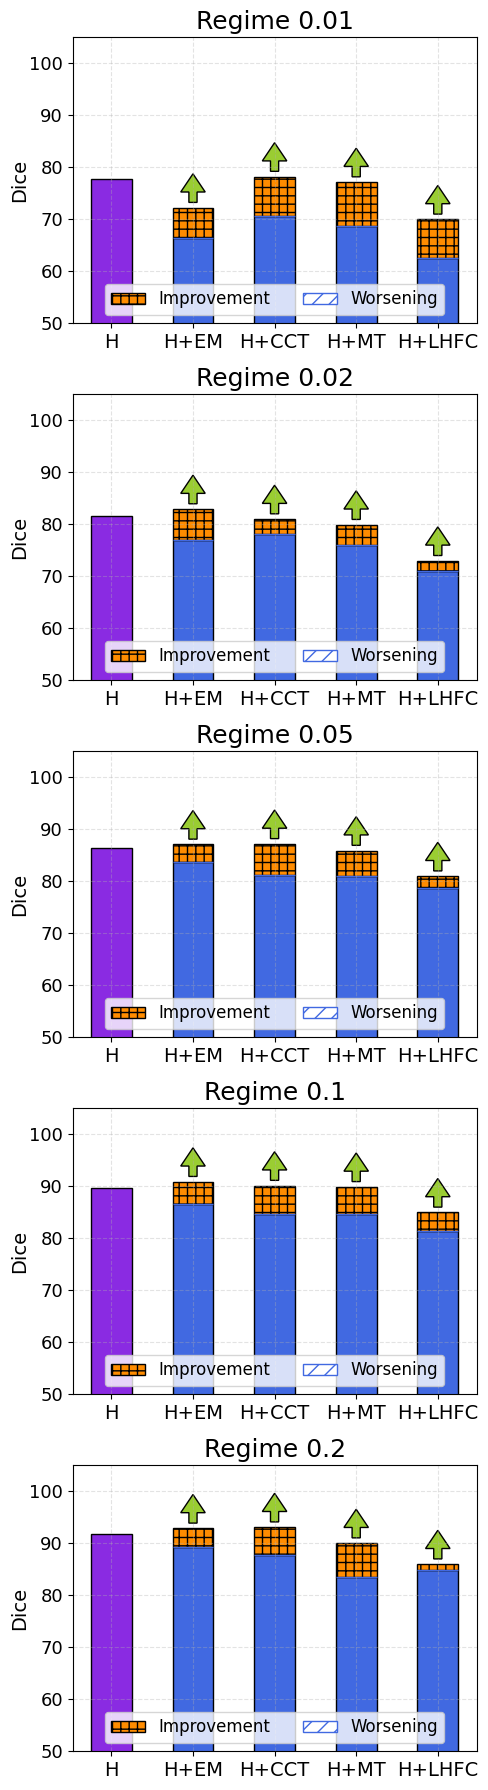

In [303]:
width=0.5

x_labels = ['H', 'H+EM', 'H+CCT', 'H+MT', 'H+LHFC']
regimes = ['0.01', '0.02', '0.05', '0.1', '0.2']

fig, axes = plt.subplots(5, 1, figsize=(5, 18), squeeze=False)

for j in range(5):
    #axes[0][j].xaxis.set_major_locator(ticker.NullLocator())
    #axes[0][j].set_xlabel("Method", fontsize=10)
    axes[j][0].tick_params(axis='x', labelrotation=0)
    axes[j][0].xaxis.set_tick_params(labelsize=14)
    axes[j][0].grid(linestyle='--', linewidth=0.8, alpha=0.35)
    axes[j][0].set_ylabel("Dice", fontsize=14, labelpad=0)
    axes[j][0].yaxis.set_tick_params(labelsize=13)
    axes[j][0].set_title('Regime {}'.format(regimes[j]), fontsize=18)
    axes[j][0].set_ylim([50, 105])


############################
# Regime 0.01
hebb_001 = [77.84, 0, 0, 0, 0]
values_001 = [0, 66.43, 70.72, 68.75, 62.54]
improvements_001 = [0, (72.25-66.43), (78.23-70.72), (77.17-68.75), (70-62.54)]
worsening_001 = [0, 0, 0, 0, 0]

axes[0,0].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[0,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,0].arrow(x=1, y=72.25+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=2, y=78.23+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=3, y=77.17+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=4, y=70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.02
hebb_001 = [81.65, 0, 0, 0, 0]
values_001 = [0, 76.92, 78.10, 75.94, 71.11]
improvements_001 = [0, (82.95-76.92), (81.02-78.10), (79.94-75.94), (73-71.11)]
worsening_001 = [0, 0, 0, 0, 0]

axes[1,0].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[1,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[1,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[1,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[1,0].arrow(x=1, y=82.95+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=2, y=81.02+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=3, y=79.94+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=4, y=73+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.05
hebb_001 = [86.43, 0, 0, 0, 0]
values_001 = [0, 83.64, 81.23, 81.01, 78.62]
improvements_001 = [0, (87.11-83.64), (87.21-81.23), (85.92-81.01), (81-78.62)]
worsening_001 = [0, 0, 0, 0, 0]

axes[2,0].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[2,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[2,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[2,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[2,0].arrow(x=1, y=87.11+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=2, y=87.21+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=3, y=85.92+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=4, y=81+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.1
hebb_001 = [89.70, 0, 0, 0, 0]
values_001 = [0, 86.57, 84.64, 84.61, 81.49]
improvements_001 = [0, (90.90-86.57), (90.15-84.64), (89.91-84.61), (85-81.49)]
worsening_001 = [0, 0, 0, 0, 0]

axes[3,0].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[3,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[3,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[3,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[3,0].arrow(x=1, y=90.90+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=2, y=90.15+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=3, y=89.91+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=4, y=85+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.2
hebb_001 = [91.70, 0, 0, 0, 0]
values_001 = [0, 89.33, 87.77, 83.55, 84.96]
improvements_001 = [0, (92.89-89.33), (93.12-87.77), (90.05-83.55), (86-84.96)]
worsening_001 = [0, 0, 0, 0, 0]

axes[4,0].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[4,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[4,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[4,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[4,0].arrow(x=1, y=92.89+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=2, y=93.12+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=3, y=90.05+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=4, y=86+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].legend(ncol=2, fontsize=12, loc='lower center')

plt.tight_layout()
plt.savefig("./figures/ph2_plots_v.pdf", format="pdf", bbox_inches="tight")
plt.show()

<h3>GlaS Dataset</h3>

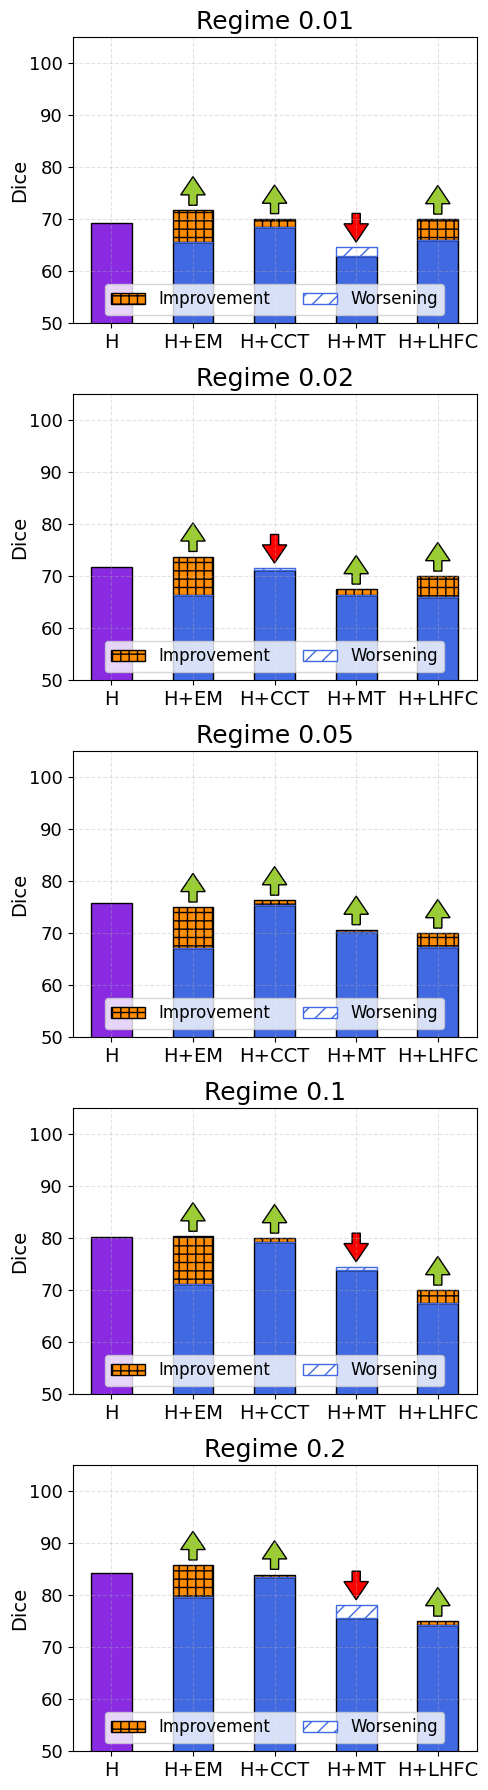

In [304]:
width=0.5

x_labels = ['H', 'H+EM', 'H+CCT', 'H+MT', 'H+LHFC']
regimes = ['0.01', '0.02', '0.05', '0.1', '0.2']

fig, axes = plt.subplots(5, 1, figsize=(5, 18), squeeze=False)

for j in range(5):
    #axes[0][j].xaxis.set_major_locator(ticker.NullLocator())
    #axes[0][j].set_xlabel("Method", fontsize=10)
    axes[j][0].tick_params(axis='x', labelrotation=0)
    axes[j][0].xaxis.set_tick_params(labelsize=14)
    axes[j][0].grid(linestyle='--', linewidth=0.8, alpha=0.35)
    axes[j][0].set_ylabel("Dice", fontsize=14, labelpad=0)
    axes[j][0].yaxis.set_tick_params(labelsize=13)
    axes[j][0].set_title('Regime {}'.format(regimes[j]), fontsize=18)
    axes[j][0].set_ylim([50, 105])


############################
# Regime 0.01
hebb_001 = [69.32, 0, 0, 0, 0]
values_001 = [0, 65.58, 68.45, 64.63-(64.63-62.85), 65.96]
improvements_001 = [0, (71.70-65.58), (70.09-68.45), 0, (70-65.96)]
worsening_001 = [0, 0, 0, (64.63-62.85), 0]

axes[0,0].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[0,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,0].arrow(x=1, y=71.70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=2, y=70.09+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=3, y=64.63+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=4, y=70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.02
hebb_002 = [71.87, 0, 0, 0, 0]
values_002 = [0, 66.42, 71.54-(71.54-71.19), 66.46, 66.00]
improvements_002 = [0, (73.78-66.42), 0, (67.50-66.46), (70-66.00)]
worsening_002 = [0, 0, (71.54-71.19), 0, 0]

axes[1,0].bar(x_labels, hebb_002, width=width, edgecolor="black", color='blueviolet')
axes[1,0].bar(x_labels, values_002, width=width, edgecolor="black", color='royalblue')
axes[1,0].bar(x_labels, improvements_002, bottom=values_002, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[1,0].bar(x_labels, worsening_002, bottom=values_002, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[1,0].arrow(x=1, y=73.78+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=2, y=71.54+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=3, y=67.50+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=4, y=70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.05
hebb_005 = [75.84, 0, 0, 0, 0]
values_005 = [0, 67.14, 75.35, 70.31, 67.36]
improvements_005 = [0, (75.02-67.14), (76.33-75.35), (70.66-70.31), (70-67.36)]
worsening_005 = [0, 0, 0, 0, 0]

axes[2,0].bar(x_labels, hebb_005, width=width, edgecolor="black", color='blueviolet')
axes[2,0].bar(x_labels, values_005, width=width, edgecolor="black", color='royalblue')
axes[2,0].bar(x_labels, improvements_005, bottom=values_005, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[2,0].bar(x_labels, worsening_005, bottom=values_005, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[2,0].arrow(x=1, y=75.02+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=2, y=76.33+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=3, y=70.66+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=4, y=70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.1
hebb_01 = [80.17, 0, 0, 0, 0]
values_01 = [0, 71.29, 79.34, 74.49-(74.49-73.86), 67.63]
improvements_01 = [0, (80.36-71.29), (80-79.34), 0, (70-67.63)]
worsening_01 = [0, 0, 0, (74.49-73.86), 0]

axes[3,0].bar(x_labels, hebb_01, width=width, edgecolor="black", color='blueviolet')
axes[3,0].bar(x_labels, values_01, width=width, edgecolor="black", color='royalblue')
axes[3,0].bar(x_labels, improvements_01, bottom=values_01, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[3,0].bar(x_labels, worsening_01, bottom=values_01, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[3,0].arrow(x=1, y=80.36+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=2, y=80+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=3, y=74.49+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=4, y=70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.2
hebb_02 = [84.20, 0, 0, 0, 0]
values_02 = [0, 79.61, 83.60, 78.14-(78.14-75.58), 74.25]
improvements_02 = [0, (85.80-79.61), (84-83.60), 0, (75-74.25)]
worsening_02 = [0, 0, 0, (78.14-75.58), 0]

axes[4,0].bar(x_labels, hebb_02, width=width, edgecolor="black", color='blueviolet')
axes[4,0].bar(x_labels, values_02, width=width, edgecolor="black", color='royalblue')
axes[4,0].bar(x_labels, improvements_02, bottom=values_02, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[4,0].bar(x_labels, worsening_02, bottom=values_02, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[4,0].arrow(x=1, y=85.80+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=2, y=84+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=3, y=78.14+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=4, y=75+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].legend(ncol=2, fontsize=12, loc='lower center')

plt.tight_layout()
plt.savefig("./figures/glas_plots_v.pdf", format="pdf", bbox_inches="tight")
plt.show()

<h3>Human Eyes Dataset</h3>

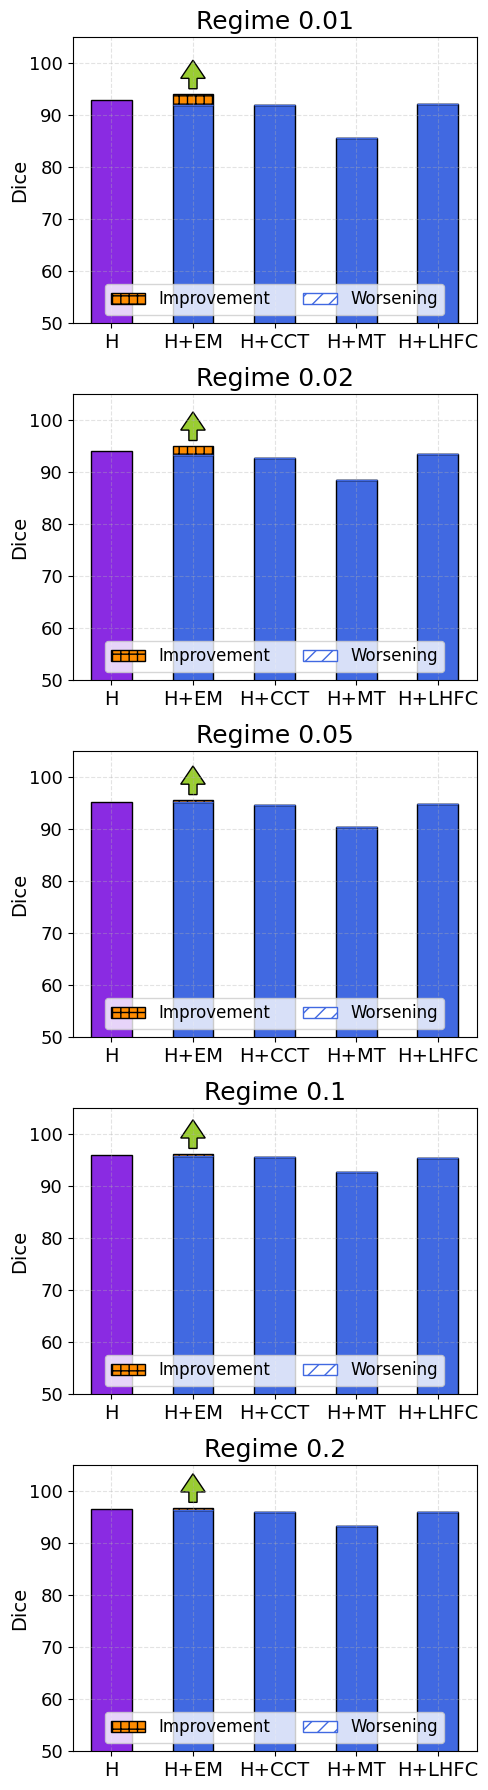

In [302]:
width=0.5

x_labels = ['H', 'H+EM', 'H+CCT', 'H+MT', 'H+LHFC']
regimes = ['0.01', '0.02', '0.05', '0.1', '0.2']

fig, axes = plt.subplots(5, 1, figsize=(5, 18), squeeze=False)

for j in range(5):
    #axes[0][j].xaxis.set_major_locator(ticker.NullLocator())
    #axes[0][j].set_xlabel("Method", fontsize=10)
    axes[j][0].tick_params(axis='x', labelrotation=0)
    axes[j][0].xaxis.set_tick_params(labelsize=14)
    axes[j][0].grid(linestyle='--', linewidth=0.8, alpha=0.35)
    axes[j][0].set_ylabel("Dice", fontsize=14, labelpad=0)
    axes[j][0].yaxis.set_tick_params(labelsize=13)
    axes[j][0].set_title('Regime {}'.format(regimes[j]), fontsize=18)
    axes[j][0].set_ylim([50, 105])


############################
# Regime 0.01
hebb_001 = [93.02, 0, 0, 0, 0]
values_001 = [0, 91.94, 92.00, 85.73, 92.22]
improvements_001 = [0, (94.11-91.94), 0, 0, 0]
worsening_001 = [0, 0, 0, 0, 0]

axes[0,0].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[0,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,0].arrow(x=1, y=94.11+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=2, y=0+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=3, y=0+10, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=4, y=0+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.02
hebb_002 = [94.10, 0, 0, 0, 0]
values_002 = [0, 93.26, 92.81, 88.58, 93.50]
improvements_002 = [0, (95.12-93.26), 0, 0, 0]
worsening_002 = [0, 0, 0, 0, 0]

axes[1,0].bar(x_labels, hebb_002, width=width, edgecolor="black", color='blueviolet')
axes[1,0].bar(x_labels, values_002, width=width, edgecolor="black", color='royalblue')
axes[1,0].bar(x_labels, improvements_002, bottom=values_002, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[1,0].bar(x_labels, worsening_002, bottom=values_002, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[1,0].arrow(x=1, y=95.12+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=2, y=0+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=3, y=0+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=4, y=0+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.05
hebb_005 = [95.27, 0, 0, 0, 0]
values_005 = [0, 95.16, 94.61, 90.37, 94.82]
improvements_005 = [0, (95.68-95.16), 0, 0, 0]
worsening_005 = [0, 0, 0, 0, 0]

axes[2,0].bar(x_labels, hebb_005, width=width, edgecolor="black", color='blueviolet')
axes[2,0].bar(x_labels, values_005, width=width, edgecolor="black", color='royalblue')
axes[2,0].bar(x_labels, improvements_005, bottom=values_005, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[2,0].bar(x_labels, worsening_005, bottom=values_005, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[2,0].arrow(x=1, y=95.68+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=2, y=0+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=3, y=0+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=4, y=0+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.1
hebb_01 = [96.04, 0, 0, 0, 0]
values_01 = [0, 95.79, 95.62, 92.66, 95.52]
improvements_01 = [0, (96.29-95.79), 0, 0, 0]
worsening_01 = [0, 0, 0, 0, 0]

axes[3,0].bar(x_labels, hebb_01, width=width, edgecolor="black", color='blueviolet')
axes[3,0].bar(x_labels, values_01, width=width, edgecolor="black", color='royalblue')
axes[3,0].bar(x_labels, improvements_01, bottom=values_01, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[3,0].bar(x_labels, worsening_01, bottom=values_01, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[3,0].arrow(x=1, y=96.29+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=2, y=0+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=3, y=0+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=4, y=0+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.2
hebb_02 = [96.57, 0, 0, 0, 0]
values_02 = [0, 96.40, 96.00, 93.26, 96.08]
improvements_02 = [0, (96.88-96.40), 0, 0, 0]
worsening_02 = [0, 0, 0, 0, 0]

axes[4,0].bar(x_labels, hebb_02, width=width, edgecolor="black", color='blueviolet')
axes[4,0].bar(x_labels, values_02, width=width, edgecolor="black", color='royalblue')
axes[4,0].bar(x_labels, improvements_02, bottom=values_02, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[4,0].bar(x_labels, worsening_02, bottom=values_02, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[4,0].arrow(x=1, y=96.88+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=2, y=0+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=3, y=0+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=4, y=0+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].legend(ncol=2, fontsize=12, loc='lower center')

plt.tight_layout()
plt.savefig("./figures/human_eyes_plots_v.pdf", format="pdf", bbox_inches="tight")
plt.show()

<h2>Horizontal Version</h2>

<h3>PH2 Dataset</h3>

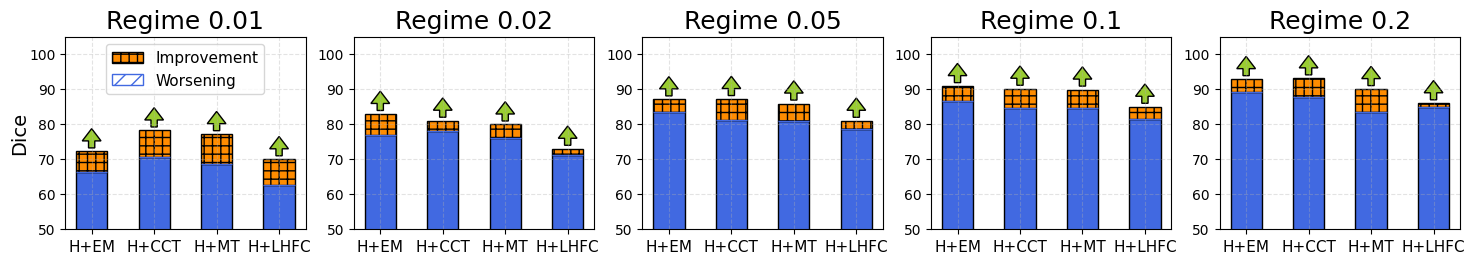

In [59]:
width=0.5

x_labels = ['H+EM', 'H+CCT', 'H+MT', 'H+LHFC']
regimes = ['0.01', '0.02', '0.05', '0.1', '0.2']

fig, axes = plt.subplots(1, 5, figsize=(18, 2.5), squeeze=False)

for j in range(5):
    #axes[0][j].xaxis.set_major_locator(ticker.NullLocator())
    #axes[0][j].set_xlabel("Method", fontsize=10)
    axes[0][j].tick_params(axis='x', labelrotation=0)
    axes[0][j].xaxis.set_tick_params(labelsize=11)
    axes[0][j].grid(linestyle='--', linewidth=0.8, alpha=0.35)
    #axes[0][j].set_ylabel("Dice", fontsize=14, labelpad=-5)
    axes[0][j].yaxis.set_tick_params(labelsize=10)
    axes[0][j].set_title('Regime {}'.format(regimes[j]), fontsize=18)
    axes[0][j].set_ylim([50, 105])

axes[0][0].set_ylabel("Dice", fontsize=14, labelpad=0)


############################
# Regime 0.01
values_001 = [66.43, 70.72, 68.75, 62.54]
improvements_001 = [(72.25-66.43), (78.23-70.72), (77.17-68.75), (70-62.54)]
worsening_001 = [0, 0, 0, 0]

axes[0,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,0].arrow(x=0, y=72.25+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=1, y=78.23+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=2, y=77.17+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=3, y=70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].legend(ncol=1, fontsize=11, loc='upper center')

############################
# Regime 0.02
values_001 = [76.92, 78.10, 75.94, 71.11]
improvements_001 = [(82.95-76.92), (81.02-78.10), (79.94-75.94), (73-71.11)]
worsening_001 = [0, 0, 0, 0]

axes[0,1].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,1].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,1].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,1].arrow(x=0, y=82.95+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=1, y=81.02+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=2, y=79.94+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=3, y=73+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[1,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.05
values_001 = [83.64, 81.23, 81.01, 78.62]
improvements_001 = [(87.11-83.64), (87.21-81.23), (85.92-81.01), (81-78.62)]
worsening_001 = [0, 0, 0, 0]

axes[0,2].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,2].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,2].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,2].arrow(x=0, y=87.11+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=1, y=87.21+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=2, y=85.92+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=3, y=81+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[2,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.1
values_001 = [86.57, 84.64, 84.61, 81.49]
improvements_001 = [(90.90-86.57), (90.15-84.64), (89.91-84.61), (85-81.49)]
worsening_001 = [0, 0, 0, 0]

axes[0,3].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,3].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,3].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,3].arrow(x=0, y=90.90+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=1, y=90.15+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=2, y=89.91+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=3, y=85+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[3,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.2
values_001 = [89.33, 87.77, 83.55, 84.96]
improvements_001 = [(92.89-89.33), (93.12-87.77), (90.05-83.55), (86-84.96)]
worsening_001 = [0, 0, 0, 0]

axes[0,4].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,4].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,4].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,4].arrow(x=0, y=92.89+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=1, y=93.12+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=2, y=90.05+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=3, y=86+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[4,0].legend(ncol=2, fontsize=12, loc='lower center')


#plt.tight_layout()
plt.subplots_adjust(wspace=.2, hspace=.1)
plt.savefig("./figures/ph2_plots_h.pdf", format="pdf", bbox_inches="tight")
plt.show()

<h3>GlaS Dataset</h3>

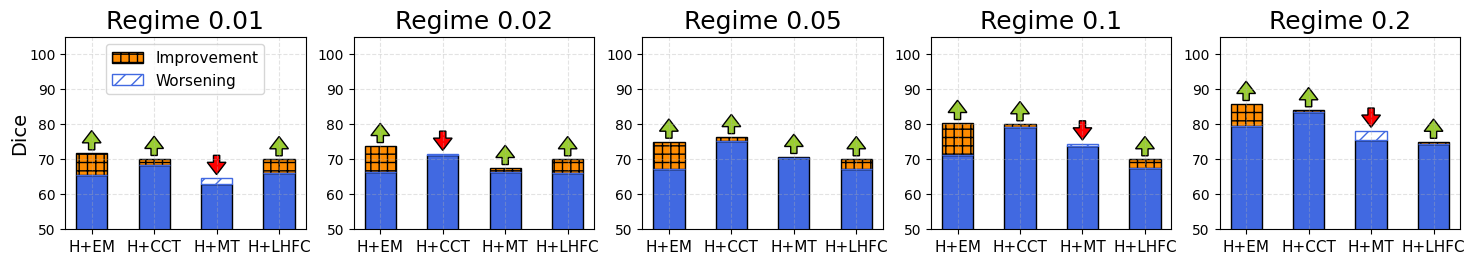

In [71]:
width=0.5

x_labels = ['H+EM', 'H+CCT', 'H+MT', 'H+LHFC']
regimes = ['0.01', '0.02', '0.05', '0.1', '0.2']

fig, axes = plt.subplots(1, 5, figsize=(18, 2.5), squeeze=False)

for j in range(5):
    #axes[0][j].xaxis.set_major_locator(ticker.NullLocator())
    #axes[0][j].set_xlabel("Method", fontsize=10)
    axes[0][j].tick_params(axis='x', labelrotation=0)
    axes[0][j].xaxis.set_tick_params(labelsize=11)
    axes[0][j].grid(linestyle='--', linewidth=0.8, alpha=0.35)
    #axes[0][j].set_ylabel("Dice", fontsize=14, labelpad=-5)
    axes[0][j].yaxis.set_tick_params(labelsize=10)
    axes[0][j].set_title('Regime {}'.format(regimes[j]), fontsize=18)
    axes[0][j].set_ylim([50, 105])

axes[0][0].set_ylabel("Dice", fontsize=14, labelpad=0)


############################
# Regime 0.01
values_001 = [65.58, 68.45, 64.63-(64.63-62.85), 65.96]
improvements_001 = [(71.70-65.58), (70.09-68.45), 0, (70-65.96)]
worsening_001 = [0, 0, (64.63-62.85), 0]

axes[0,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,0].arrow(x=0, y=71.70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=1, y=70.09+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=2, y=64.63+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=3, y=70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].legend(ncol=1, fontsize=11, loc='upper center')

############################
# Regime 0.02
values_002 = [66.42, 71.54-(71.54-71.19), 66.46, 66.00]
improvements_002 = [(73.78-66.42), 0, (67.50-66.46), (70-66.00)]
worsening_002 = [0, (71.54-71.19), 0, 0]

axes[0,1].bar(x_labels, values_002, width=width, edgecolor="black", color='royalblue')
axes[0,1].bar(x_labels, improvements_002, bottom=values_002, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,1].bar(x_labels, worsening_002, bottom=values_002, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,1].arrow(x=0, y=73.78+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=1, y=71.54+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=2, y=67.50+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=3, y=70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[1,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.05
values_005 = [67.14, 75.35, 70.31, 67.36]
improvements_005 = [(75.02-67.14), (76.33-75.35), (70.66-70.31), (70-67.36)]
worsening_005 = [0, 0, 0, 0]

axes[0,2].bar(x_labels, values_005, width=width, edgecolor="black", color='royalblue')
axes[0,2].bar(x_labels, improvements_005, bottom=values_005, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,2].bar(x_labels, worsening_005, bottom=values_005, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,2].arrow(x=0, y=75.02+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=1, y=76.33+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=2, y=70.66+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=3, y=70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[0,2].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.1
values_01 = [71.29, 79.34, 74.49-(74.49-73.86), 67.63]
improvements_01 = [(80.36-71.29), (80-79.34), 0, (70-67.63)]
worsening_01 = [0, 0, (74.49-73.86), 0]

axes[0,3].bar(x_labels, values_01, width=width, edgecolor="black", color='royalblue')
axes[0,3].bar(x_labels, improvements_01, bottom=values_01, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,3].bar(x_labels, worsening_01, bottom=values_01, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,3].arrow(x=0, y=80.36+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=1, y=80+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=2, y=74.49+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=3, y=70+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[3,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.2
values_02 = [79.61, 83.60, 78.14-(78.14-75.58), 74.25]
improvements_02 = [(85.80-79.61), (84-83.60), 0, (75-74.25)]
worsening_02 = [0, 0, (78.14-75.58), 0]

axes[0,4].bar(x_labels, values_02, width=width, edgecolor="black", color='royalblue')
axes[0,4].bar(x_labels, improvements_02, bottom=values_02, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,4].bar(x_labels, worsening_02, bottom=values_02, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,4].arrow(x=0, y=85.80+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=1, y=84+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=2, y=78.14+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=3, y=75+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[4,0].legend(ncol=2, fontsize=12, loc='lower center')


#plt.tight_layout()
plt.subplots_adjust(wspace=.2, hspace=.1)
plt.savefig("./figures/glas_plots_h.pdf", format="pdf", bbox_inches="tight")
plt.show()

<h3>HMEPS</h3>

/tmp/ipykernel_1097109/1737279575.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0][j].set_yticklabels(y_labels[:-2])
/tmp/ipykernel_1097109/1737279575.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0][j].set_yticklabels(y_labels[:-2])
/tmp/ipykernel_1097109/1737279575.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0][j].set_yticklabels(y_labels[:-2])
/tmp/ipykernel_1097109/1737279575.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0][j].set_yticklabels(y_labels[:-2])
/tmp/ipykernel_1097109/1737279575.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or u

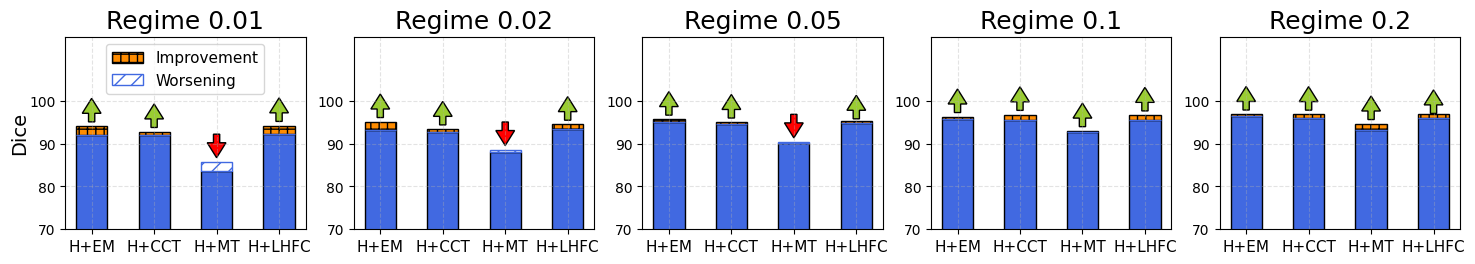

In [65]:
width=0.5

x_labels = ['H+EM', 'H+CCT', 'H+MT', 'H+LHFC']
y_labels = ['70', '80', '90', '100', '110', '115']
regimes = ['0.01', '0.02', '0.05', '0.1', '0.2']

fig, axes = plt.subplots(1, 5, figsize=(18, 2.5), squeeze=False)

for j in range(5):
    #axes[0][j].xaxis.set_major_locator(ticker.NullLocator())
    #axes[0][j].set_xlabel("Method", fontsize=10)
    axes[0][j].tick_params(axis='x', labelrotation=0)
    axes[0][j].xaxis.set_tick_params(labelsize=11)
    axes[0][j].grid(linestyle='--', linewidth=0.8, alpha=0.35)
    #axes[0][j].set_ylabel("Dice", fontsize=14, labelpad=-5)
    axes[0][j].yaxis.set_tick_params(labelsize=10)
    axes[0][j].set_title('Regime {}'.format(regimes[j]), fontsize=18)
    axes[0][j].set_ylim([70, 115])
    axes[0][j].set_yticklabels(y_labels[:-2])
    yticks = axes[0][j].yaxis.get_major_ticks()
    yticks[-1].set_visible(False)
    yticks[-2].set_visible(False)
    #axes[0][j].margins(None, 500)

axes[0][0].set_ylabel("Dice", fontsize=14, labelpad=0)


############################
# Regime 0.01
values_001 = [91.94, 92.00, 85.73-((85.73-83.63)), 92.22]
improvements_001 = [(94.11-91.94), (92.80-92.00), 0, (94.22-92.22)]
worsening_001 = [0, 0, (85.73-83.63), 0]

axes[0,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,0].arrow(x=0, y=94.11+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=1, y=92.80+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=2, y=85.73+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=3, y=94.22+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].legend(ncol=1, fontsize=11, loc='upper center')

############################
# Regime 0.02
values_002 = [93.26, 92.81, 88.58-(88.58-88.14), 93.50]
improvements_002 = [(95.12-93.26), (93.40-92.81), 0, (94.50-93.50)]
worsening_002 = [0, 0, (88.58-88.14), 0]

axes[0,1].bar(x_labels, values_002, width=width, edgecolor="black", color='royalblue')
axes[0,1].bar(x_labels, improvements_002, bottom=values_002, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,1].bar(x_labels, worsening_002, bottom=values_002, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,1].arrow(x=0, y=95.12+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=1, y=93.40+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=2, y=88.58+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=3, y=94.50+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[0,1].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.05
values_005 = [95.16, 94.61, 90.37-(90.37-90.19), 94.82]
improvements_005 = [(95.68-95.16), (95.01-94.61), 0, (95.34-94.82)]
worsening_005 = [0, 0, (90.37-90.19), 0]

axes[0,2].bar(x_labels, values_005, width=width, edgecolor="black", color='royalblue')
axes[0,2].bar(x_labels, improvements_005, bottom=values_005, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,2].bar(x_labels, worsening_005, bottom=values_005, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,2].arrow(x=0, y=95.68+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=1, y=95.01+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=2, y=90.37+1+2+3.5, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=3, y=94.82+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[0,2].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.1
values_01 = [95.79, 95.62, 92.66, 95.52]
improvements_01 = [(96.29-95.79), (96.8-95.62), (92.99-92.66), (96.67-95.52)]
worsening_01 = [0, 0, 0, 0]

axes[0,3].bar(x_labels, values_01, width=width, edgecolor="black", color='royalblue')
axes[0,3].bar(x_labels, improvements_01, bottom=values_01, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,3].bar(x_labels, worsening_01, bottom=values_01, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,3].arrow(x=0, y=96.29+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=1, y=96.8+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=2, y=92.99+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=3, y=96.67+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[0,3].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.2
values_02 = [96.40, 96.00, 93.26, 96.08]
improvements_02 = [(96.88-96.40), (96.85-96.00), (94.65-93.26), (96.88-96.08)]
worsening_02 = [0, 0, 0, 0]

axes[0,4].bar(x_labels, values_02, width=width, edgecolor="black", color='royalblue')
axes[0,4].bar(x_labels, improvements_02, bottom=values_02, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,4].bar(x_labels, worsening_02, bottom=values_02, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,4].arrow(x=0, y=96.88+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=1, y=96.85+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=2, y=94.65+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=3, y=96.08+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
#axes[0,4].legend(ncol=2, fontsize=12, loc='lower center')


#plt.tight_layout()
plt.subplots_adjust(wspace=.2, hspace=.1)
plt.savefig("./figures/hmeps_plots_h.pdf", format="pdf", bbox_inches="tight")
plt.show()